In [130]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [131]:
import numpy as np
import pandas as pd

In [132]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [133]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

In [134]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [135]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [136]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [137]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [138]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [139]:
# measurement_df=measurement_df.dropna() 

In [140]:
# station_df=station_df.dropna()

In [141]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from datetime import timedelta, datetime
# Calculate the date 1 year ago from the last data point in the database
## find the last recording date
# sql_statement='SELECT MAX(date) FROM Measurement'
max_date = session.query(func.max(Measurement.date)).all()
# print(max_date)
end_date = max_date[0][0]
# print(end_date)

## find 1 year prior to the last recording date
year = timedelta(days=365)
# print(year)
# convert last recording date to date format
end_date_ = datetime.strptime(end_date, '%Y-%m-%d')
# print(end_date_)
# begin date is last recording date minus 1 year
begin_date_ = end_date_ - year
# print(begin_date_)

In [142]:
# Perform a query to retrieve the data and precipitation scores
measurement =   session.query(Measurement).\
                filter(Measurement.date >= begin_date_, Measurement.date <= end_date_).all()

precipitation_data=[]
                
for m in measurement:
    precipitation_data.append((m.id,m.station,m.date,m.prcp,m.tobs))
# sql_statement="SELECT * FROM Measurement WHERE date BETWEEN " + "'" + begin_date + "'" + ' AND ' + "'" + end_date + "'" 
precipitation_data[:10]

[(2365, 'USC00519397', '2016-08-24', 0.08, 79.0),
 (2366, 'USC00519397', '2016-08-25', 0.08, 80.0),
 (2367, 'USC00519397', '2016-08-26', 0.0, 79.0),
 (2368, 'USC00519397', '2016-08-27', 0.0, 77.0),
 (2369, 'USC00519397', '2016-08-28', 0.01, 78.0),
 (2370, 'USC00519397', '2016-08-29', 0.0, 78.0),
 (2371, 'USC00519397', '2016-08-30', 0.0, 79.0),
 (2372, 'USC00519397', '2016-08-31', 0.13, 80.0),
 (2373, 'USC00519397', '2016-09-01', 0.0, 81.0),
 (2374, 'USC00519397', '2016-09-02', 0.0, 80.0)]

In [143]:
# precipitation =     session.query(Measurement.date, Measurement.prcp).\
#                     filter(Measurement.date >= begin_date_, Measurement.date <= end_date_).all()
# precipitation_dict = dict(precipitation)
# # precipitation_dict = list(np.ravel(precipitation))
# precipitation_dict

In [144]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df = pd.DataFrame(precipitation_data, columns =['station activity', 'station', 'date', 'prcp', 'tobs']) 
precipitation_data_df.head()

,station activity,station,date,prcp,tobs
0,2365,USC00519397,2016-08-24,0.08,79.0
1,2366,USC00519397,2016-08-25,0.08,80.0
2,2367,USC00519397,2016-08-26,0.00,79.0
3,2368,USC00519397,2016-08-27,0.00,77.0
4,2369,USC00519397,2016-08-28,0.01,78.0


In [145]:
# Sort the dataframe by date
precipitation_data_df=precipitation_data_df.sort_values('date')
precipitation_data_df=precipitation_data_df.reset_index()
precipitation_data_df.head()

,index,station activity,station,date,prcp,tobs
0,0,2365,USC00519397,2016-08-24,0.08,79.0
1,1006,8826,USC00517948,2016-08-24,NaN,78.0
2,1524,14609,USC00519281,2016-08-24,2.15,77.0
3,702,7332,USC00514830,2016-08-24,2.28,80.0
4,360,5092,USC00513117,2016-08-24,2.15,76.0


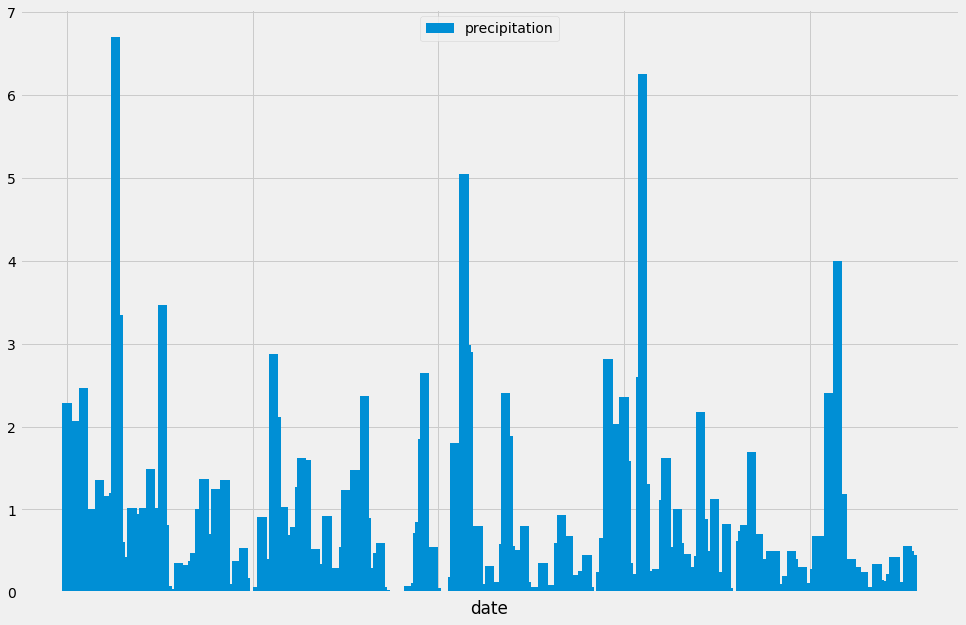

In [146]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']= (15,10)
fig = plt.figure()
fig.patch.set_facecolor('0.94')
plt.bar(precipitation_data_df['date'],precipitation_data_df['prcp'],width=4,label='precipitation')
# plot layout
plt.xlabel('date')
x_ticks=np.arange(0,365,80)
plt.xticks(x_ticks,[])
plt.legend(loc='upper center')
plt.grid(b=True, which='major', axis='both')
plt.rcParams.update({'font.size': 22})
# save plot
plt.savefig("precipitation.png")
# show plot
plt.show()

In [147]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation=pd.DataFrame(precipitation_data_df['prcp'])
precipitation.columns=['precipitation']
precipitation.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [148]:
# Design a query to show how many stations are available in this dataset?
st_av = session.query(func.count(distinct(Measurement.station)))
stations_available=[]
for s_a in st_av:
    stations_available.append(s_a)
# sql_statement="SELECT COUNT(DISTINCT(station)) AS 'number of stations' FROM Station"
stations_available

[(9)]

In [149]:
# What are the most active stations? (i.e. what stations have the most rows)? 
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.station).label('count')]
most_act =  session.query(*sel).\
            group_by(Measurement.station).\
            order_by(desc('count')).all()
# sql_statement='SELECT station, COUNT(station) AS count FROM Measurement GROUP BY station ORDER BY count DESC' 
most_act

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
# sel = [Measurement.station]
# stations =  session.query(*sel).\
#             group_by(Measurement.station).\
#             order_by(Measurement.station).all()
# stations

In [151]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
USC00519281_details = []
# sql_statement="SELECT MIN(tobs) 'lowest temperature recorded', MAX(tobs) 'highest temperature recorded', AVG(tobs) 'average temperature' FROM Measurement WHERE station = 'USC00519281'"
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

USC00519281_details = session.query(*sel).all()

USC00519281_details

[(53.0, 87.0, 73.09795396419437)]

In [152]:
# Choose the station with the highest number of temperature observations. 
# hnto: highest number of temperature observations
hnto=[]
# sql_statement="SELECT station, count(station) AS count FROM Measurement GROUP BY station ORDER BY count DESC" 
sel = [Measurement.station, 
       func.count(Measurement.station).label('count')]

hnto_sel =  session.query(*sel).\
            group_by(Measurement.station).\
            order_by(desc('count')).first()
hnto_sel

('USC00519281', 2772)

In [153]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data=[]

sel = [Measurement.date, 
       Measurement.tobs]
temp_data = session.query(*sel).\
            filter(Measurement.date >= begin_date_, Measurement.date <= end_date_).\
            filter(Measurement.station=='USC00519281').\
            order_by(Measurement.date)
# sql_statement="SELECT date, tobs  FROM Measurement WHERE ( date BETWEEN " + "'" + begin_date + "'" + ' AND ' + "'" + end_date + "')" " AND station = 'USC00519281' ORDER BY date"
               
for td in temp_data:
    temperature_data.append(td)
# sql_statement="SELECT * FROM Measurement WHERE date BETWEEN " + "'" + begin_date + "'" + ' AND ' + "'" + end_date + "'" 
temperature_data_df= pd.DataFrame(temperature_data)
temperature_data_df=temperature_data_df.rename(columns={0: 'date', 1: 'tobs'})
# list(temperature_data_df)
temperature_data_df['date'][:10]

0    2016-08-24
1    2016-08-25
2    2016-08-26
3    2016-08-27
4    2016-08-28
5    2016-08-29
6    2016-08-30
7    2016-08-31
8    2016-09-01
9    2016-09-02
Name: date, dtype: object

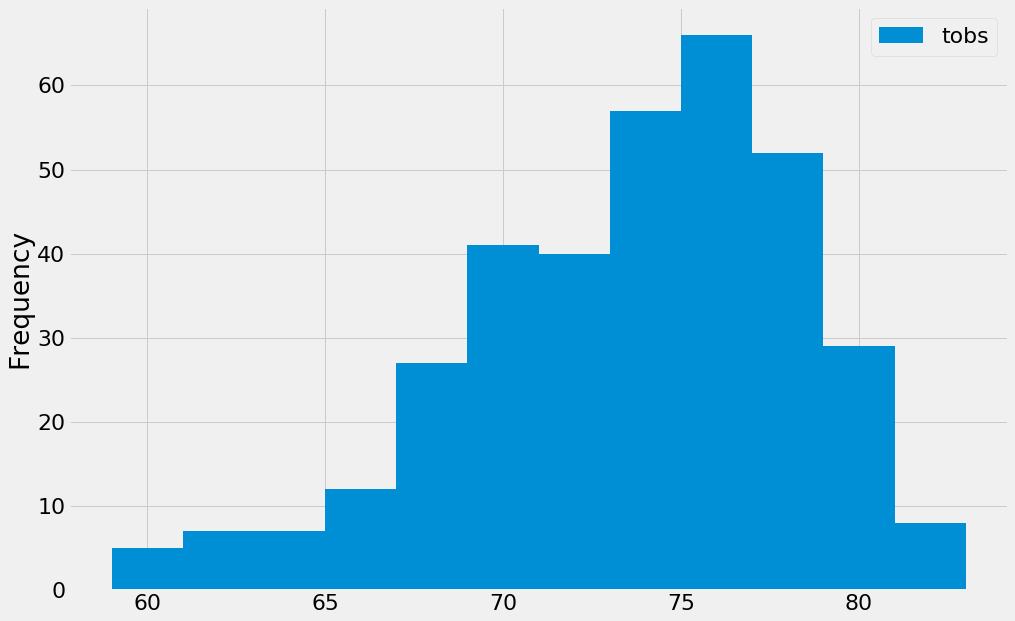

<Figure size 1080x720 with 0 Axes>

In [154]:
## histogram
bins=12 #months
fig = plt.figure()
fig.patch.set_facecolor('0.94')
n, bins, patches = plt.hist(temperature_data_df['tobs'], bins, label='tobs')
plt.ylabel('Frequency')
x_ticks=np.arange(60,80,5)
plt.legend(loc='upper right')
plt.grid(b=True, which='major', axis='both')
plt.rcParams.update({'font.size': 10})
plt.show()
# save plot
plt.savefig("tobs.png")

## Optional Challenge Assignment

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
#     TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d

#     Returns:
#         TMIN, TAVE, and TMAX
    
#     sql_statement="SELECT MIN(tobs) 'lowest temperature recorded', MAX(tobs) 'highest temperature recorded', AVG(tobs) 'average temperature' FROM Measurement WHERE date BETWEEN " + "'" + start_date  + "'" + " AND " + "'" + end_date + '"'

    sel = [func.min(Measurement.tobs), 
           func.avg(Measurement.tobs), 
           func.max(Measurement.tobs)]

    return session.query(*sel).filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [156]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
result = calc_temps(begin_date_, end_date_)
print(result)

[(58.0, 74.57894736842105, 87.0)]


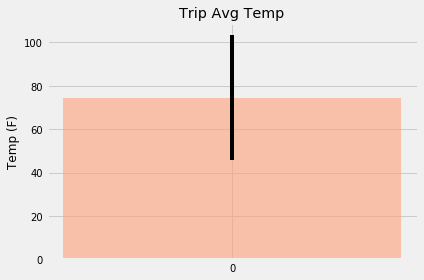

<Figure size 432x288 with 0 Axes>

In [157]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.rcParams['figure.figsize']= (6,4)

bars = (result[0][1])

fig, ax = plt.subplots()

y_ticks = np.arange(0,120,20)
 
ind = np.arange(1)  # the x locations for the groups
width = 0.1  # the width of the bars

ax.grid(b=False, which='minor', axis='both')
barchart = ax.bar(0, bars, align='center', yerr=(result[0][2]-result[0][0]),
                color='lightsalmon', alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Temp (F)') #fontsize=22
ax.set_title('Trip Avg Temp')
ax.set_yticks(y_ticks)
ax.set_xticks(ind)
fig.tight_layout()

plt.show()
# save plot
plt.savefig('trip avg temp.png')
# to do: lose 0 on x axis; adjust figure size


In [158]:
# for next query, find column names for station table
inspector = inspect(engine)
inspector.get_table_names()
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [159]:
# for next query, find column names for station table
inspector = inspect(engine)
inspector.get_table_names()
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [160]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# to do: validate numbers
sel = [ Measurement.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation, 
        func.sum(Measurement.prcp).label('sum')]

result =    session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= begin_date_, Measurement.date <= end_date_).\
            group_by(Measurement.station).\
            order_by(desc('sum')).\
            all()
result

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.11000000000004),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  68.24000000000002),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  48.36000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  37.99),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.19),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  16.089999999999986),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]

In [161]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [190]:
# calculate the daily normals for your trip
import datetime as dt

# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
trip_start_date = '2019-08-04'
trip_end_date = '2019-08-10'
trip_start = dt.datetime.strptime(trip_start_date, "%Y-%m-%d")
trip_end = dt.datetime.strptime(trip_end_date, "%Y-%m-%d")
# Use the start and end date to create a range of dates
dates = []
loop_date = trip_start
# Stip off the year and save a list of %m-%d strings
month_day = f'{str(loop_date.month).zfill(2)}-{str(loop_date.day).zfill(2)}'
dates.append(month_day)
while loop_date != trip_end:
    loop_date = loop_date + day
#    print(loop_date)
    month_day = f'{str(loop_date.month).zfill(2)}-{str(loop_date.day).zfill(2)}'
    dates.append(month_day)
# print(dates)
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for md in dates:
    normals.append(daily_normals(md))
    
normals

[[(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)],
 [(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)]]

In [191]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals)
normals_df

,0
0,"(69.0, 76.71153846153847, 84.0)"
1,"(69.0, 76.14814814814815, 82.0)"
2,"(67.0, 76.25, 83.0)"
3,"(71.0, 77.15686274509804, 83.0)"
4,"(68.0, 76.5576923076923, 83.0)"
5,"(69.0, 75.98039215686275, 81.0)"
6,"(65.0, 76.42, 83.0)"


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
